In [1]:
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from glob import glob
import pandas as pd
from copy import deepcopy
import gsw
import gen_utils
import seaborn as sns
sns.set()

to-do
- compute both speed and along-stream velocity
- plot both on same graph

# Load data

## Density

In [2]:
data  = xr.open_dataset('ctd-data.nc')
data['p'] = -gsw.z_from_p(data['p'], lat=40.3)
data = data.rename({'p':'depth'})

## Velocity
For transformed coordinate system, use projection array computed in ```lab2_load-data.ipynb```

In [3]:
transform = False
uv = xr.open_dataset('VelocityData.nc')

def velocity_xr(u_vals, v_vals):
    '''Put velocity values in xarray dataarray'''
    # Put on correct grid    
    velocity = xr.DataArray(np.stack([u_vals,v_vals],axis=0), 
                            coords={'name':['u','v'], 'p'   :uv['DepthCenterCell'].values,
                                    'dist':uv['DistanceCenterCell'].values/1000, # convert to km
                                    'time':data.time[::-1]}, dims=['name','time','p','dist'])
    velocity['p'] = -gsw.z_from_p(velocity['p'], lat=40.3) # convert pressure to depth
    velocity      = velocity.rename({'p':'depth'})
    velocity      = velocity.reindex(time=velocity.time[::-1]) # time dimension matches density data
    velocity      = velocity.interp({'dist':data.dist}) # interpolate distances to match density data
    return velocity

###### Transformed velocity ######
# Projection matrix
P = np.array([[ 0.44254196, -0.8967478 ],
              [ 0.8967478 ,  0.44254196]])
uv = xr.open_dataset('VelocityData.nc')
u  = uv['AllUArray'].values
v  = uv['AllVArray'].values

# Get transformed velocities
uv_stack = np.stack([u,v],axis=0)
uvhat      = (P @ uv_stack.reshape(2,-1)).reshape(uv_stack.shape)
uhat, vhat = uvhat[0], uvhat[1]
velocity_transformed = velocity_xr(uhat,vhat)

###### Speed ###########
v = np.sqrt(uv['AllUArray']**2 + uv['AllVArray']**2).values
u = 0 * deepcopy(v)
velocity = velocity_xr(u,v)
    
# # Put on correct grid    
#  = xr.DataArray(speed_vals, coords={'dist':uv['DistanceCenterCell'].values/1000, # convert to km
#                                              'p'   :uv['DepthCenterCell'].values,
#                                              'time':data.time[::-1]}, dims=['time','p','dist'])
# speed['p'] = -gsw.z_from_p(speed['p'], lat=40.3) # convert pressure to depth
# speed      = speed.rename({'p':'depth'})
# speed      = speed.reindex(time=speed.time[::-1]) # time dimension matches density data
# speed      = speed.interp({'dist':data.dist}) # interpolate distances to match density data

Compute geostrophic velocity based on "reduced gravity'' equations:  
$fv = g\nabla \eta_1$  
$\implies v = \frac{g}{f}\frac{\partial\eta_1}{\partial x}$

In [4]:
def get_ym(data, idx):
    '''Get year and month from the data, given data and index'''
    time = data.time.isel(time=idx)
    y    = time.dt.year.values.item()
    m    = time.dt.month.values.item()
    return y, m

def get_iso(data, x):
    '''Given a dataset and the value of an isopycnal/therm, get coordinates of isopycnal/therm'''
    levels = np.array([x])
    idx = np.where(levels==x)[0].item()
    p = plt.contour(data['dist'], data['depth'], data['T'].T, levels=levels)
    plt.close()
    c = p.allsegs[idx][np.argmax([len(y) for y in p.allsegs[idx]])]
    return c

def get_iso_xr(data,x):
    '''Get isotherm, and horizontal gradient of the isotherm, from data'''
    iso = get_iso(data,x)
    iso = xr.DataArray(iso[:,1], coords={'dist':pd.Index(iso[:,0])}, dims=['dist'])
    iso = iso.drop_duplicates('dist').interp(dist=data['dist'])
    grad  = iso.differentiate('dist') / 1000 # convert from km to m
    return iso, grad

def get_lower_upper(data, iso):
    '''Get quantity averaged over lower and upper layers of the 1.5 layer model'''
    lower_list, upper_list = [], []
    for d in data.dist:
        boundary  = iso.sel(dist=d).values.item() 
        lower_list.append(data.sel(dist=d, depth=slice(boundary,None)).mean('depth').values.item())
        upper_list.append(data.sel(dist=d, depth=slice(None,boundary)).mean('depth').values.item())
    return np.array(lower_list), np.array(upper_list)

def get_gprime(data, iso):
    '''Compute reduced gravity, based on isotherm/isopycnal'''
    rho_lower, rho_upper = get_lower_upper(data['rho'], iso)
    gprime = deepcopy(iso)
    gprime.values = 9.8 * (rho_lower-rho_upper) / (rho_upper + 1000) #
    return gprime

def est_velocity(data,x):
    '''Get estimated velocity from data, based on selected iso-line'''
    g     = 9.8 # acceleration due to gravity (NEED TO COMPUTE REDUCED GRAVITY!!!)
    omega = 2*np.pi/(3600*24) # rotation rate of earth (radians/sec)
    f     = 2*omega*np.sin(np.deg2rad(40.3)) # estimate of f0, based on latitude of ~40 degrees N
    iso, grad = get_iso_xr(data,x)    # Get isoline and compute horizontal gradient
    gprime    = get_gprime(data, iso) # Compute reduced gravity
    v         = gprime / f * grad    # velocity
    return iso, grad, v

# Theoretical velocity

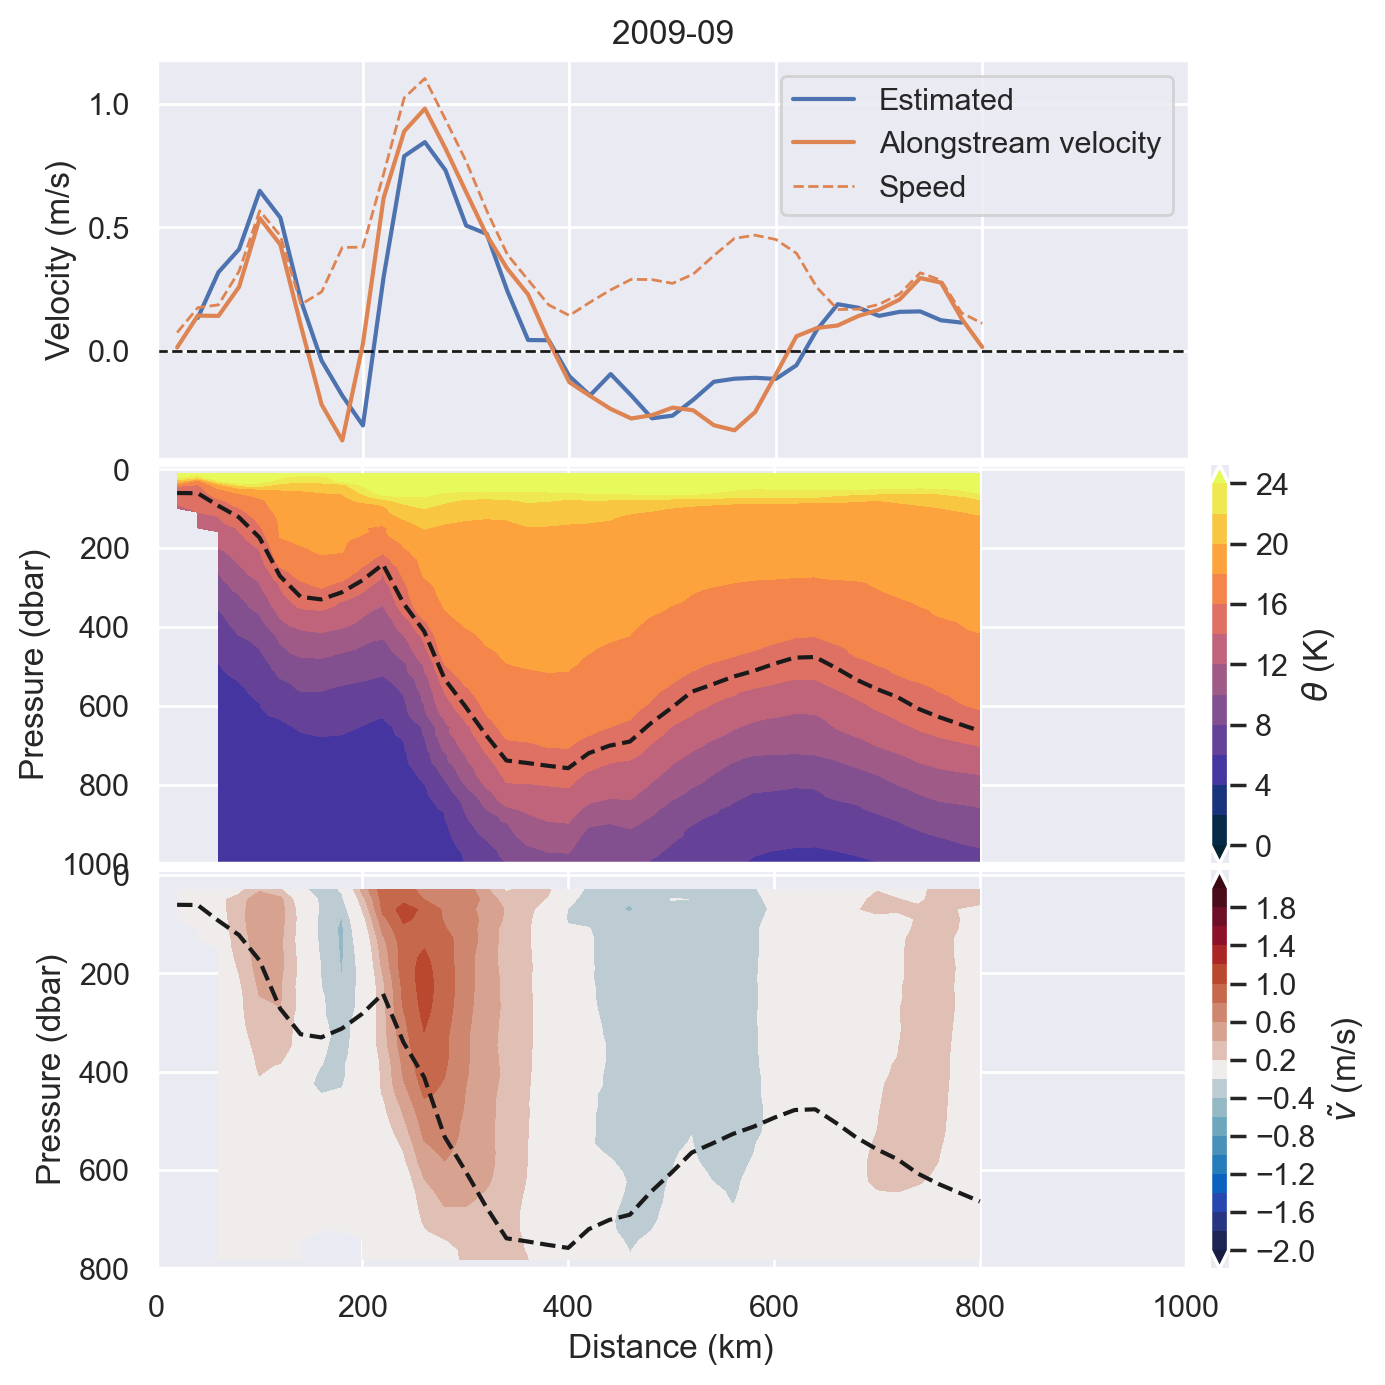

In [11]:
mpl.rcParams['figure.dpi'] = 200

time_idx  = 5
iso_level = 15

iso, grad, v             = est_velocity(data.isel(time=time_idx), iso_level)
speed_lower, speed_upper = get_lower_upper(velocity.sel(name='v').isel(time=time_idx), iso)
vhat_lower,  vhat_upper  = get_lower_upper(velocity_transformed.sel(name='v').isel(time=time_idx), iso)

c = sns.color_palette()

figsize = np.array([8,8])
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(30,30)

#### Land vs. Ocean #####
ax0 = fig.add_subplot(gs[:10,:25])
p1 = ax0.plot(v.dist, v.values, label='Estimated')
p2 = ax0.plot(v.dist, vhat_upper,  color=c[1], label='Alongstream velocity')
p2 = ax0.plot(v.dist, speed_upper, color=c[1], label='Speed', ls='--', lw=1)
# du = ax0.contourf(np.array([[]]), np.array([[]]))
ax0.set_xticklabels([])
ax0.axhline(0,ls='--',lw=1,c='k')
ax0.set_xlim([0,1000])
ax0.set_ylabel('Velocity (m/s)')
ax0.legend()
y,m = get_ym(data, time_idx)
ax0.set_title(f'{y}-{m:02d}')

#### Plot Temperature profile ###
ax = fig.add_subplot(gs[10:20,:])
p = ax.contourf(data.dist, data.depth, data.isel(time=time_idx)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
cb = fig.colorbar(p, orientation='vertical', pad=.02, label=r'$\theta$ (K)')
ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xticklabels([])
ax.set_ylim([-10,1000])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down


#### Plot Velocity profile ####
ax = fig.add_subplot(gs[20:30,:])
p = ax.contourf(velocity.dist, velocity.depth, velocity_transformed.sel(name='v').isel(time=time_idx), 
                cmap='cmo.balance', levels=gen_utils.make_cb_range(2,.2), extend='both')
cb = fig.colorbar(p, orientation='vertical', label=r'$\tilde{v}$ (m/s)', pad=.02)
ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,800])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

plt.show()

Compare:
- accuracy with different isotherms/isopycnals
- using potential density vs. potential temperature

# Plot

## Density

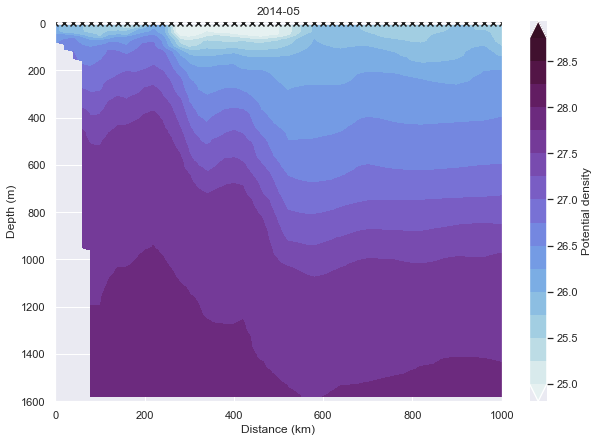

In [4]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.depth, data.isel(time=i)['rho'].T, cmap='cmo.dense',
               levels=np.arange(25,29,.25), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Potential density') # create colorbar
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()

## Temperature

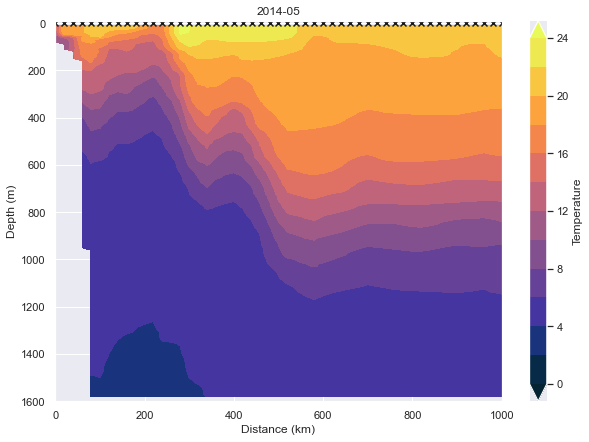

In [5]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.depth, data.isel(time=i)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Temperature') # create colorbar
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()